# Analog circuit for preparing a Bell state

Bell states are maximally entangled, two-qubit states that are ubiquitous in quantum information tasks. Here, we will create the analog quantum program to prepare the two-qubit Bell state,

$$
| \psi \rangle = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)
$$

First, we import the relevant libraries and OQD modules.


In [1]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from oqd_analog_emulator.qutip_backend import QutipBackend
from oqd_core.backend.metric import Expectation
from oqd_core.backend.task import Task, TaskArgsAnalog
from oqd_core.interface.analog.operation import AnalogCircuit, AnalogGate
from oqd_core.interface.analog.operator import PauliI, PauliX, PauliY, PauliZ

warnings.filterwarnings("ignore")

Next, we define the one- and two qubit Rabi frequencies and the control Hamiltonians.


In [2]:
X, Y, Z, I = PauliX(), PauliY(), PauliZ(), PauliI()  # noqa: E741

n = 2  # number of qubits

# 1-qubit & 2-qubit Rabi frequencies
w1 = 2 * np.pi * 1
w2 = 2 * np.pi * 0.1

In [3]:
Hii = AnalogGate(hamiltonian=I @ I)
Hxi = AnalogGate(hamiltonian=X @ I)
Hyi = AnalogGate(hamiltonian=Y @ I)
Hxx = AnalogGate(hamiltonian=X @ X)
Hmix = AnalogGate(hamiltonian=-1 * (I @ X))
Hmxi = AnalogGate(hamiltonian=-1 * (X @ I))
Hmyi = AnalogGate(hamiltonian=-1 * (Y @ I))

Now, we apply these Hamiltonians sequentially on the two qubits to prepare the entangled state and measure the whole system.


In [4]:
circuit = AnalogCircuit()

# Hadamard
circuit.evolve(duration=(3 * np.pi) / 2, gate=Hii)
circuit.evolve(duration=np.pi / 2, gate=Hxi)
circuit.evolve(duration=np.pi / 4, gate=Hmyi)

# CNOT
circuit.evolve(duration=np.pi / 4, gate=Hyi)
circuit.evolve(duration=np.pi / 4, gate=Hxx)
circuit.evolve(duration=np.pi / 4, gate=Hmix)
circuit.evolve(duration=np.pi / 4, gate=Hmxi)
circuit.evolve(duration=np.pi / 4, gate=Hmyi)
circuit.evolve(duration=np.pi / 4, gate=Hii)

circuit.measure()

Finally, we can emulate the circuit evolution using a classical emulation and track the $Z_1$ and $Z_2$ expectation values.


In [5]:
args = TaskArgsAnalog(
    n_shots=1000,
    fock_cutoff=4,
    metrics={
        "Z_0": Expectation(operator=(Z @ I)),
        "Z_1": Expectation(operator=(I @ Z)),
    },
    dt=1e-2,
)
task = Task(program=circuit, args=args)

In [6]:
backend = QutipBackend()
results = backend.run(task=task)

[1/1] Cythonizing qtcoeff_9935efd7b07a5b0c7f90e15bb1eec4.pyx
running build_ext
building 'qtcoeff_9935efd7b07a5b0c7f90e15bb1eec4' extension
"C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.42.34433\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -Id:\work\Projects\equilux\.venv\Lib\site-packages\qutip\core\data -Id:\work\Projects\equilux\.venv\Lib\site-packages\numpy\core\include -Id:\work\Projects\equilux\.venv\include -IC:\Users\Salieri\AppData\Roaming\uv\python\cpython-3.12.9-windows-x86_64-none\include -IC:\Users\Salieri\AppData\Roaming\uv\python\cpython-3.12.9-windows-x86_64-none\Include "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.42.34433\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.42.34433\ATLMFC\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Fi

Finally, we visualize and plot the results for the circuit evolution and the resultant state.


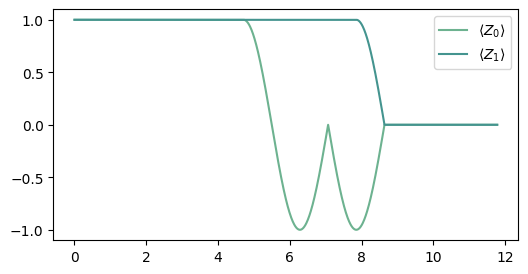

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=4)

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.legend()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[Text(0.5, 0, 'Basis state'),
 Text(0, 0.5, 'Amplitude (imag)'),
 (-3.141592653589793, 3.141592653589793)]

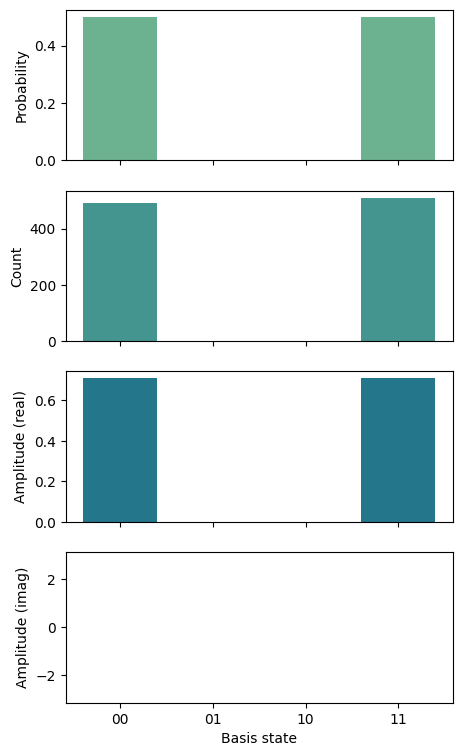

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = ["".join(bits) for bits in itertools.product("01", repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state) ** 2, color=colors[0])
ax.set(ylabel="Probability")


ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")

ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi])